##### Copyright 2018 The TensorFlow Authors.

In [680]:
# Code Modified from Keras Tutorial on TensorFlow

# Basic Regression Model to predict Gaze Point

In [681]:
!pip install -q seaborn

In [682]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np




In [683]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


### Get training and test data

In [684]:
# Change Precision
np.set_printoptions(precision=3, suppress=True)
# For training
filename = r'merged_dot_test.csv'
# For validation
filename2 = r'merged3.csv'
column_names = ['eye_0_x' ,'eye_0_y', 'eye_1_x', 'eye_1_y' ,'gaze_angle_x','gaze_angle_y', 'tobiiLeftScreenGazeY']

# Are we testing Left or Right Screen GAze
gaze_var = 'tobiiLeftScreenGazeY'

df = pd.read_csv(filename)
df =  df[column_names]
# Get names of indexes when LTG == -1
indexNames1 = df[ df[gaze_var] == -1.0 ].index
indexNames1a = df[ df[gaze_var] > 2 ].index
# Delete these row indexes from the df
df.drop(indexNames1 , inplace=True)
df.drop(indexNames1a , inplace=True)

# Test data
test_df = pd.read_csv(filename2)
test_df =  test_df[column_names]
indexNames2 = test_df[ test_df[gaze_var] == -1.0 ].index
indexNames2a = df[ df[gaze_var] > 2 ].index
test_df.drop(indexNames2 , inplace=True)
test_df.drop(indexNames2a , inplace=True)
print(test_df)


      eye_0_x  eye_0_y  eye_1_x  eye_1_y  gaze_angle_x  gaze_angle_y  \
0          45       89      121       81     -0.043704     -0.231694   
1          44       87      122       80     -0.146455     -0.268709   
2          45       86      122       80     -0.108768     -0.296484   
5          48       93      124       86      0.057631     -0.243795   
6          47       93      123       86      0.010699     -0.268294   
...       ...      ...      ...      ...           ...           ...   
7647       49       90      124       85      0.064027     -0.213448   
7648       46       91      120       86      0.065854     -0.208040   
7649       48       92      122       86      0.085070     -0.211834   
7650       48       90      122       85      0.089742     -0.224310   
7651       47       91      121       86      0.088497     -0.223410   

      tobiiLeftScreenGazeY  
0                 0.308210  
1                 0.327303  
2                 0.327303  
5                 0

In [685]:
dataset = df.copy()
dataset.tail()

# Print shape of the dataframe
#df.shape[0]

,eye_0_x,eye_0_y,eye_1_x,eye_1_y,gaze_angle_x,gaze_angle_y,tobiiLeftScreenGazeY
666,NaN,NaN,NaN,NaN,NaN,NaN,0.886929
667,NaN,NaN,NaN,NaN,NaN,NaN,0.889010
668,NaN,NaN,NaN,NaN,NaN,NaN,0.889561
669,NaN,NaN,NaN,NaN,NaN,NaN,0.891926
670,NaN,NaN,NaN,NaN,NaN,NaN,0.888585


In [686]:
# Print shape of the dataframe 
# Size when -1s are deleted
df.shape[0]

542

In [687]:
test_dataset = test_df.copy()
test_dataset.tail()

,eye_0_x,eye_0_y,eye_1_x,eye_1_y,gaze_angle_x,gaze_angle_y,tobiiLeftScreenGazeY
7647,49,90,124,85,0.064027,-0.213448,NaN
7648,46,91,120,86,0.065854,-0.208040,NaN
7649,48,92,122,86,0.085070,-0.211834,NaN
7650,48,90,122,85,0.089742,-0.224310,NaN
7651,47,91,121,86,0.088497,-0.223410,NaN


### Clean the data

The dataset contains a few unknown values.

In [688]:
dataset.isna().sum()
test_dataset.isna().sum()

eye_0_x                    0
eye_0_y                    0
eye_1_x                    0
eye_1_y                    0
gaze_angle_x               0
gaze_angle_y               0
tobiiLeftScreenGazeY    6596
dtype: int64

Get rid of na values

In [689]:
dataset = dataset.dropna()
test_dataset = dataset.dropna()
test_dataset.shape[0]

532

In [690]:
train_dataset = dataset
test_dataset = test_dataset

Plot vars against eachother

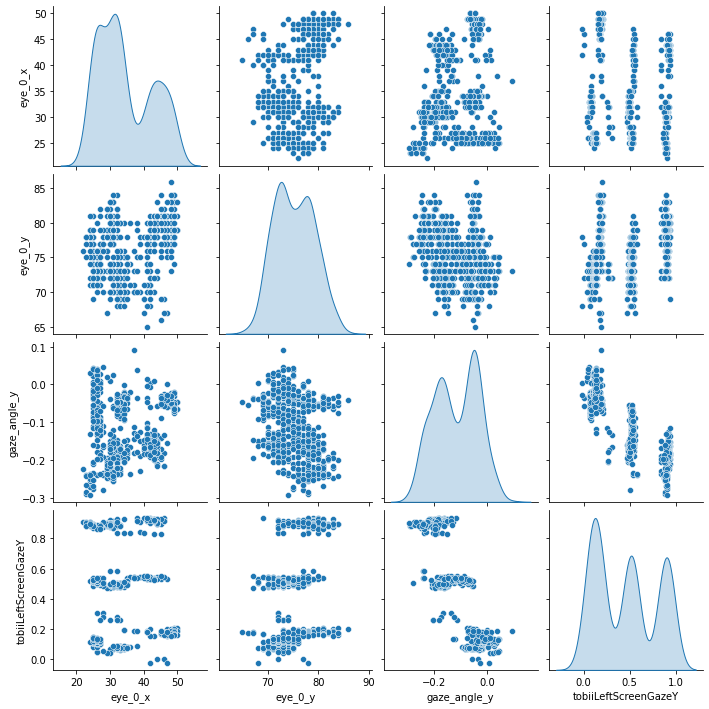

In [691]:
sns.pairplot(train_dataset[['eye_0_x', 'eye_0_y','gaze_angle_y', gaze_var]], diag_kind='kde')

Check range of the variables etc. 
tobii gaze is a functional of them all

In [692]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
eye_0_x,532.0,34.436090,7.901325,22.000000,27.000000,32.000000,42.000000,50.000000
eye_0_y,532.0,75.242481,3.925800,65.000000,72.000000,75.000000,78.000000,86.000000
eye_1_x,532.0,94.150376,8.616759,79.000000,86.000000,94.000000,102.000000,110.000000
eye_1_y,532.0,77.078947,3.438643,67.000000,75.000000,77.000000,79.000000,87.000000
gaze_angle_x,532.0,-0.076760,0.278978,-0.571919,-0.376402,-0.072257,0.206339,0.381206
gaze_angle_y,532.0,-0.116326,0.081119,-0.292152,-0.181782,-0.114948,-0.048390,0.092684
tobiiLeftScreenGazeY,532.0,0.456173,0.323334,-0.022475,0.133627,0.497838,0.879184,0.938070


### Split features from labels

Separate the target value, the "label", from the features. This label is used to train model

In [693]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(gaze_var)
test_labels = test_features.pop(gaze_var)

## Normalisation

The ranges are quite small in this case

In [694]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
eye_0_x,34.436090,7.901325
eye_0_y,75.242481,3.925800
eye_1_x,94.150376,8.616759
eye_1_y,77.078947,3.438643
gaze_angle_x,-0.076760,0.278978
gaze_angle_y,-0.116326,0.081119
tobiiLeftScreenGazeY,0.456173,0.323334


It is good practice to normalize features that use different scales and ranges. 
Normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization`--> Preprocess

Create layer:

In [695]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [696]:
normalizer.adapt(np.array(train_features))

Calculate mean and variance, store it in the layer

In [697]:
print(normalizer.mean.numpy())

[34.436 75.242 94.15  77.079 -0.077 -0.116]


When the layer is called it returns the input data, with each feature independently normalized:

In [698]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[33.   73.   94.   77.   -0.05 -0.11]]

Normalized: [[-0.18 -0.57 -0.02 -0.02  0.09  0.02]]


## Linear regression

Before building a DNN model,we try a linear regression.

### One Variable

Start with a single-variable linear regression, to predict 'gaze_angle_y' from eye_y


In [699]:
gaze_y = np.array(train_features['gaze_angle_y'])

gaze_y_normalizer = preprocessing.Normalization(input_shape=[1,])
gaze_y_normalizer.adapt(gaze_y)

In [700]:
gaze_y_model = tf.keras.Sequential([
    gaze_y_normalizer,
    layers.Dense(units=1)
])

gaze_y_model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_27 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [701]:
gaze_y_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [702]:
gaze_y_model.predict(gaze_y[:10])

array([[-0.034],
       [-0.765],
       [-2.064],
       [-3.754],
       [-2.764],
       [-1.429],
       [-0.995],
       [-1.162],
       [-1.125],
       [-1.334]], dtype=float32)

Once the training is configured, use `Model.fit()` to execute the training:

In [703]:
%%time
history = gaze_y_model.fit(
    train_features['gaze_angle_y'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 11.8 s


Visualize the model's training progress using the stats stored in the `history` object.

In [704]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.129042,0.271307,95
96,0.127691,0.160457,96
97,0.128524,0.281003,97
98,0.129488,0.213954,98
99,0.131573,0.221401,99


In [705]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Tobii Right Screen Gaze Y]')
  plt.legend()
  plt.grid(True)

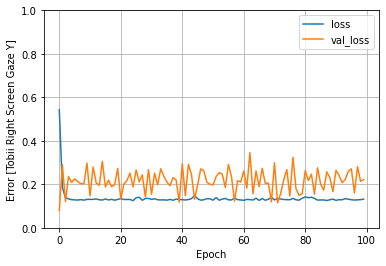

In [706]:
plot_loss(history)

Collect the results on the test set, for later:

In [707]:
test_results = {}

test_results['gaze_y_model'] = gaze_x_model.evaluate(
    test_features['gaze_angle_y'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [708]:
x = tf.linspace(-0.75, 0.5, 10)
y = gaze_x_model.predict(x)

In [709]:
def plot_gaze_y(x, y):
  plt.scatter(train_features['gaze_angle_y'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Gaze Angle y')
  plt.ylabel('Tobii Right Screen Y')
  plt.legend()

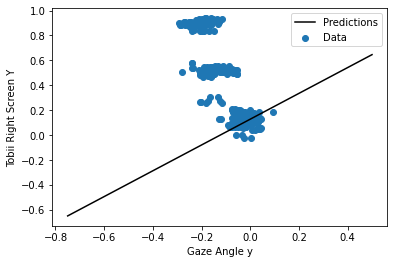

In [710]:
plot_gaze_y(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [711]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [712]:
linear_model.predict(train_features[:10])

array([[0.176],
       [0.953],
       [2.248],
       [3.382],
       [2.702],
       [1.642],
       [1.102],
       [1.304],
       [1.139],
       [1.032]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [713]:
linear_model.layers[1].kernel

<tf.Variable 'dense_124/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.399],
       [-0.261],
       [-0.621],
       [ 0.033],
       [ 0.725],
       [ 0.902]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [714]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [715]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 9.41 s


Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

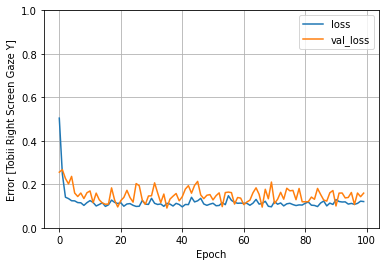

In [716]:
plot_loss(history)


Collect the results on the test set, for later:

In [717]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [718]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Gaze_y"

In [719]:
dnn_gaze_y_model = build_and_compile_model(gaze_y_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [720]:
dnn_gaze_y_model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_27 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_125 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_126 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_127 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_128 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 9         
Total params: 6,644
Trainable params: 6,641
Non-trainable params: 3
___________________________________________________

Train the model:

In [721]:
%%time

history = dnn_gaze_y_model.fit(
    train_features['gaze_angle_y'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 9.32 s


This model does slightly better than the linear-gaze_y model.

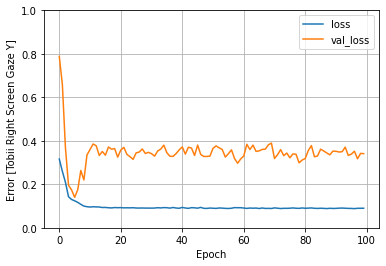

In [722]:
plot_loss(history)

If you plot the predictions as a function of gaze_y. Takes advantageof normalisation provided

In [723]:
x = tf.linspace(-0.35, 0.3, 10)
y = dnn_gaze_y_model.predict(y)

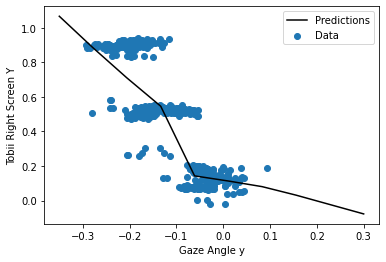

In [724]:
plot_gaze_y(x, y)

Collect the results on the test set, for later:

In [725]:
test_results['dnn_gaze_y_model'] = dnn_gaze_y_model.evaluate(
    test_features['gaze_angle_y'], test_labels,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [726]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_26 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_130 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_131 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_132 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_133 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_134 (Dense)            (None, 1)                 9         
Total params: 6,974
Trainable params: 6,961
Non-trainable params: 13
__________________________________________________

In [727]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 9.24 s


In [728]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.014009,0.274948,95
96,0.015910,0.272375,96
97,0.015314,0.273625,97
98,0.013422,0.275913,98
99,0.013496,0.266553,99


Collect the results on the test set:

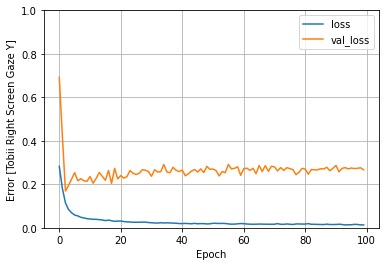

In [729]:
plot_loss(history)

In [730]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [731]:
pd.DataFrame(test_results, index=['Mean absolute error [Tobbi Right Gaze x]']).T

,Mean absolute error [Tobbi Right Gaze x]
gaze_y_model,0.457320
linear_model,0.136381
dnn_gaze_y_model,0.138889
dnn_model,0.063061


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

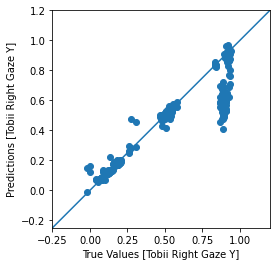

In [732]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Tobii Right Gaze Y]')
plt.ylabel('Predictions [Tobii Right Gaze Y]')
lims = [-0.25, 1.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

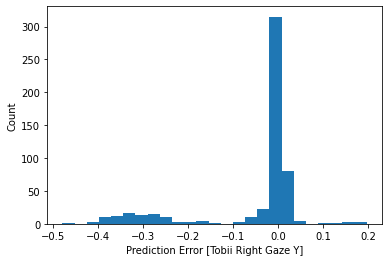

In [733]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Tobii Right Gaze Y]')
_ = plt.ylabel('Count')

Saving model:

In [734]:
dnn_model.save('dnn_2_model')

INFO:tensorflow:Assets written to: dnn_2_model\assets


Reloading Gives similar results

In [735]:
reloaded = tf.keras.models.load_model('dnn_2_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [736]:
pd.DataFrame(test_results, index=['Mean absolute error [Tobii Left Gaze Y]']).T

,Mean absolute error [Tobii Left Gaze Y]
gaze_y_model,0.457320
linear_model,0.136381
dnn_gaze_y_model,0.138889
dnn_model,0.063061
reloaded,0.063061
